# Machine learning on EMR - data exploration notebook

In the tutorial, we will attempt to predict the <i>ActualDeliveryDate</i> of packages. This is a regression problem. In order to carry out this task, we must first take a look at the data available to us, hence it is worth following through this notebook. A suggested way is to use EMR Notebooks.

## Install necessary packages

While there are [several ways](https://docs.amazonaws.cn/en_us/emr/latest/ManagementGuide/emr-managed-notebooks-installing-libraries-and-kernels.html) to install packages in the EMR notebooks' environment, we will be using the <i>sc.install_pypi_package</i>.

We first upgrade pip to a newer version. Failing to do so would cause the installation of cython to hang.

In [1]:
sc.install_pypi_package("pip==23.0", "https://pypi.org/simple --quiet")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1675256002269_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


  Cache entry deserialization failed, entry ignored

In [2]:
sc.install_pypi_package("matplotlib==2.2.5", "https://pypi.org/simple --quiet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.install_pypi_package("cython", "https://pypi.org/simple --quiet")
sc.install_pypi_package("setuptools", "https://pypi.org/simple --quiet")
sc.install_pypi_package("pandas==1.2.5", "https://pypi.org/simple --quiet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
sc.install_pypi_package("sparkhistogram", "https://pypi.org/simple --quiet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
sc.install_pypi_package("seaborn==0.10.1", "https://pypi.org/simple --quiet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Import packages

The below packages will be used throughout this tutorial.

In [6]:
import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
from pyspark.sql.functions import col, when, sum as sum_spark, to_date, udf, sqrt, pow as pow_spark

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

By default, the matplotlib backend will be set to <i>TkAgg</i>, which is not available in this environment, thus would cause the library to fail. We therefore set the backend to <i>Agg</i>. Despite being an engine intended for saving to files (read [here](https://matplotlib.org/stable/users/explain/backends.html)), it will alow us to show plots in the notebook thanks to the <i>%matplot plt</i> magic command.

In [9]:
import matplotlib
print(f"Original backend: {matplotlib.get_backend()}")
matplotlib.use('Agg')
print(f"Updated backend: {matplotlib.get_backend()}")
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Original backend: TkAgg
Updated backend: agg

In [10]:
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
from sparkhistogram import computeHistogram

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Load the data

We will be working with a <b>Ssupply chain delivery on-time</b> dataset, available under the [Amazon SageMaker Canvas Immersion Day, Lab 7](https://catalog.us-east-1.prod.workshops.aws/workshops/80ba0ea5-7cf9-4b8c-9d3f-1cd988b6c071/en-US/7-supply-chain) tutorial. The dataset consists of two csv files:
- [Shipping logs](https://static.us-east-1.prod.workshops.aws/public/2fc0479e-b78e-414f-8934-ed82eb04cbfd/static/datasets/ShippingLogs.csv)
- [Product Description](https://static.us-east-1.prod.workshops.aws/public/2fc0479e-b78e-414f-8934-ed82eb04cbfd/static/datasets/ProductDescriptions.csv)

The files should be uploaded to an S3 bucket before continuing with the excersise. Please note down the two S3 URIs. You can copy/paste them by first clicking into the specific file

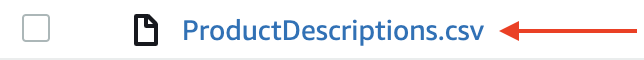

and clicking the <i>Copy S3 URI</i> button (top-right corner).

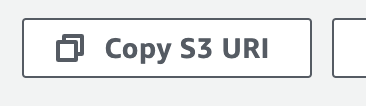

While the workshop mentioned above provides some insight about the dataset, for the sake of this demonstration, let us assume that <i>a priori</i> we do not have information about the number of rows, available columns etc. We will therefore carry out an EDA (Exploratory Data Analysis) using PySpark.

### Provide S3 locations of shipping logs and product description

In [13]:
shipping_logs_s3_path = "s3://PATH-TO-DATA/ShippingLogs.csv"
product_description_s3_path = "s3://PATH-TO-DATA/ProductDescriptions.csv"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Create PySpark dataframes from provided CSV files

We will use <i>spark.read.csv</i> method along with the "header" option set to true. This will ensure the first row will be used to determine the columns of the dataframe.

In [14]:
shipping_logs_df = spark.read.option("header", True).option("inferSchema", True).csv(shipping_logs_s3_path)
product_description_df = spark.read.option("header", True).option("inferSchema", True).csv(product_description_s3_path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Data exploration

### Describe the loaded dataframes

Let us determine the basic properties associated with the considered dataframes. A natural first step is to determine the number of rows and columns:

In [15]:
def print_rows_count_and_column_names_with_types(df, df_name=None):
    of_name_substring = f" of {df_name}" if df_name is not None else ""
    print(f"Number of rows{of_name_substring}: {df.count()}")
    print(f"Schema{of_name_substring} ({len(df.columns)} columns in total):")
    df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print_rows_count_and_column_names_with_types(shipping_logs_df, "shipping logs")
print()
print_rows_count_and_column_names_with_types(product_description_df, "product description")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows of shipping logs: 10000
Schema of shipping logs (12 columns in total):
root
 |-- ActualShippingDays: integer (nullable = true)
 |-- ExpectedShippingDays: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- YShippingDistance: integer (nullable = true)
 |-- XShippingDistance: integer (nullable = true)
 |-- InBulkOrder: string (nullable = true)
 |-- ShippingOrigin: string (nullable = true)
 |-- OrderDate: string (nullable = true)
 |-- OrderID: string (nullable = true)
 |-- ShippingPriority: string (nullable = true)
 |-- OnTimeDelivery: string (nullable = true)
 |-- ProductId: string (nullable = true)


Number of rows of product description: 120
Schema of product description (5 columns in total):
root
 |-- ComputerBrand: string (nullable = true)
 |-- ComputerModel: string (nullable = true)
 |-- ScreenSize: double (nullable = true)
 |-- PackageWeight: double (nullable = true)
 |-- ProductId: string (nullable = true)

We will next use the [describe](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.describe.html) method to gain basic information about the loaded dataframes' columns.

Please note that many Spark/PySpark methods are lazy, therefore calling them in isolation will not yield much information:

In [17]:
shipping_logs_df.describe()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[summary: string, ActualShippingDays: string, ExpectedShippingDays: string, Carrier: string, YShippingDistance: string, XShippingDistance: string, InBulkOrder: string, ShippingOrigin: string, OrderDate: string, OrderID: string, ShippingPriority: string, OnTimeDelivery: string, ProductId: string]

In order to calculate and show the results, we must follow the method call with a call to <i>show</i>:

In [18]:
shipping_logs_df.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+--------------------+-------+-----------------+------------------+------------+--------------+---------+--------------------+----------------+--------------+--------------------+
|summary|ActualShippingDays|ExpectedShippingDays|Carrier|YShippingDistance| XShippingDistance| InBulkOrder|ShippingOrigin|OrderDate|             OrderID|ShippingPriority|OnTimeDelivery|           ProductId|
+-------+------------------+--------------------+-------+-----------------+------------------+------------+--------------+---------+--------------------+----------------+--------------+--------------------+
|  count|             10000|               10000|  10000|            10000|             10000|       10000|         10000|    10000|               10000|           10000|         10000|               10000|
|   mean|           14.4423|             13.2514|   null|          -0.0466|            0.1734|        null|          null|     null|                null|            null|  

When showing a long list of dataframe columns, you may notice that the formatting makes it difficult to read the results. We can implement a workaround to show the columns in chunks.

In [19]:
def show_in_chunks(df, chunk_size=5):
    df = df.cache()
    number_of_chunks = np.ceil(len(df.columns) / chunk_size).astype(int)
    column_names = df.columns
    for chunk_idx in range(number_of_chunks):
        df.select(column_names[chunk_idx * chunk_size : (chunk_idx + 1) * chunk_size]).show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
show_in_chunks(shipping_logs_df.describe())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+--------------------+-------+-----------------+
|summary|ActualShippingDays|ExpectedShippingDays|Carrier|YShippingDistance|
+-------+------------------+--------------------+-------+-----------------+
|count  |10000             |10000               |10000  |10000            |
|mean   |14.4423           |13.2514             |null   |-0.0466          |
|stddev |3.3935265303561697|2.213659429272457   |null   |126.6152580489297|
|min    |0                 |1                   |BigBird|-476             |
|max    |28                |22                  |Shipper|537              |
+-------+------------------+--------------------+-------+-----------------+

+------------------+------------+--------------+---------+------------------------------------+
|XShippingDistance |InBulkOrder |ShippingOrigin|OrderDate|OrderID                             |
+------------------+------------+--------------+---------+------------------------------------+
|10000             |10000  

In [21]:
show_in_chunks(product_description_df.describe())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+-------------+------------------+-----------------+
|summary|ComputerBrand|ComputerModel|ScreenSize        |PackageWeight    |
+-------+-------------+-------------+------------------+-----------------+
|count  |120          |120          |120               |120              |
|mean   |null         |null         |13.859999999999987|5.882499999999999|
|stddev |null         |null         |2.448748608554818 |1.099401097465908|
|min    |Bell         |Base         |10.1              |4.0              |
|max    |Orange       |Standard     |18.4              |8.3              |
+-------+-------------+-------------+------------------+-----------------+

+------------------------------------+
|ProductId                           |
+------------------------------------+
|120                                 |
|null                                |
|null                                |
|0041d1a3-a1b4-45a9-ad5b-570a49e70178|
|fd684507-1958-4173-95db-8ff453063333|
+-----------

The shipping logs dataframe contains 10000 entries in 12 columns, while product description contains 120 entries with 5 columns. The property on which to join the entries is "ProductId".

### Join the dataframes

The join method should be a left outer join, as it still would make sense to consider orders with missing properties. On the other side, since the dataframe containing the label that will be predicted is contained within the shipment logs, a natural course of action is to drop entries that, for a given row in product description, do not have a counterpart in shipment logs.

In [22]:
df = shipping_logs_df.join(product_description_df, on="ProductId", how="left").cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Non-null/null entries

After joining the dataframes, we should check whether the dataframe contains null entries. If so, they will later need to be handled during preprocessing, before passing the data to the machine learning model.

In [23]:
def get_nonnull_fractions(df):
    num_rows = df.count()
    return df.select([
        it for c in df.columns
        for it in
        (
            (sum_spark(when(col(c).isNotNull(), 1).otherwise(0)) / num_rows).alias(f"{c}_nonnull_fraction"),
            sum_spark(when(col(c).isNotNull(), 1).otherwise(0)).alias(f"{c}_nonnull_count"),
            (sum_spark(when(col(c).isNull(), 1).otherwise(0)) > 0).alias(f"{c}_contains_null")
        )
    ])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
show_in_chunks(get_nonnull_fractions(df), chunk_size=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------+-----------------------+-----------------------+
|ProductId_nonnull_fraction|ProductId_nonnull_count|ProductId_contains_null|
+--------------------------+-----------------------+-----------------------+
|1.0                       |10000                  |false                  |
+--------------------------+-----------------------+-----------------------+

+-----------------------------------+--------------------------------+--------------------------------+
|ActualShippingDays_nonnull_fraction|ActualShippingDays_nonnull_count|ActualShippingDays_contains_null|
+-----------------------------------+--------------------------------+--------------------------------+
|1.0                                |10000                           |false                           |
+-----------------------------------+--------------------------------+--------------------------------+

+-------------------------------------+----------------------------------+-------------------

The considered (merged) dataframe does not contain any null entries, thus the current state of the data does not require value imputation before passing to the machine learning model. However, in case of a production environment, in which new data continuously flows in and model retraining is done periodically, an approach one could take is:
- Still add a data imputation step to make sure the pipeline doesn't break in case new data contains new values;
- Put in place a data quality monitoring tool to catch such changes.

### Divide columns to categories

In [25]:
numerical_types = set(["int", "double", "float"])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
date_columns = set(["OrderDate"])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
numerical_columns = [c for c, dtype in df.dtypes if dtype in numerical_types]
categorical_columns = [
    c 
    for c, dtype in df.dtypes 
    if dtype not in numerical_types
    and dtype not in date_columns
    and not c.lower().endswith("id")
    and c != "OrderDate"
]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
print(f"Numerical columns: {', '.join(numerical_columns)}")
print(f"Categorical columns: {', '.join(categorical_columns)}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Numerical columns: ActualShippingDays, ExpectedShippingDays, YShippingDistance, XShippingDistance, ScreenSize, PackageWeight
Categorical columns: Carrier, InBulkOrder, ShippingOrigin, ShippingPriority, OnTimeDelivery, ComputerBrand, ComputerModel

We will need to handle the <i>OrderDate</i> column separately, as the data type has been inferred as string, not date.

In [29]:
def reformat_date(date):
    if date is None:
        return date
    month, day, year = date.split("/")
    month = f"0{month}" if len(month) == 1 else month
    day = f"0{day}" if len(day) == 1 else day
    year = f"20{year}"
    return f"{year}-{month}-{day}"

reformat_date_udf = udf(reformat_date)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
for c in date_columns:
    df = df.withColumn(c, to_date(reformat_date_udf(col(c))))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Finally, we can print the schema again to make sure the data types are correct:

In [31]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- ProductId: string (nullable = true)
 |-- ActualShippingDays: integer (nullable = true)
 |-- ExpectedShippingDays: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- YShippingDistance: integer (nullable = true)
 |-- XShippingDistance: integer (nullable = true)
 |-- InBulkOrder: string (nullable = true)
 |-- ShippingOrigin: string (nullable = true)
 |-- OrderDate: date (nullable = true)
 |-- OrderID: string (nullable = true)
 |-- ShippingPriority: string (nullable = true)
 |-- OnTimeDelivery: string (nullable = true)
 |-- ComputerBrand: string (nullable = true)
 |-- ComputerModel: string (nullable = true)
 |-- ScreenSize: double (nullable = true)
 |-- PackageWeight: double (nullable = true)

In [32]:
show_in_chunks(df.select(numerical_columns).describe())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+--------------------+-----------------+------------------+
|summary|ActualShippingDays|ExpectedShippingDays|YShippingDistance|XShippingDistance |
+-------+------------------+--------------------+-----------------+------------------+
|count  |10000             |10000               |10000            |10000             |
|mean   |14.4423           |13.2514             |-0.0466          |0.1734            |
|stddev |3.3935265303561697|2.213659429272457   |126.6152580489297|127.16778089158306|
|min    |0                 |1                   |-476             |-436              |
|max    |28                |22                  |537              |458               |
+-------+------------------+--------------------+-----------------+------------------+

+------------------+-----------------+
|ScreenSize        |PackageWeight    |
+------------------+-----------------+
|10000             |10000            |
|13.860000000000888|5.883239999999971|
|2.4386460791738434|1

### Examine numerical columns

In [33]:
hist_exp_shipping_days = computeHistogram(df, "ExpectedShippingDays", 0, 28, 29).toPandas()
hist_act_shipping_days = computeHistogram(df, "ActualShippingDays", 0, 28, 29).toPandas()

hist_exp_shipping_days["status"] = "Expected"
hist_act_shipping_days["status"] = "Actual"

hist_shipping_days = pd.concat([hist_exp_shipping_days, hist_act_shipping_days], ignore_index=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

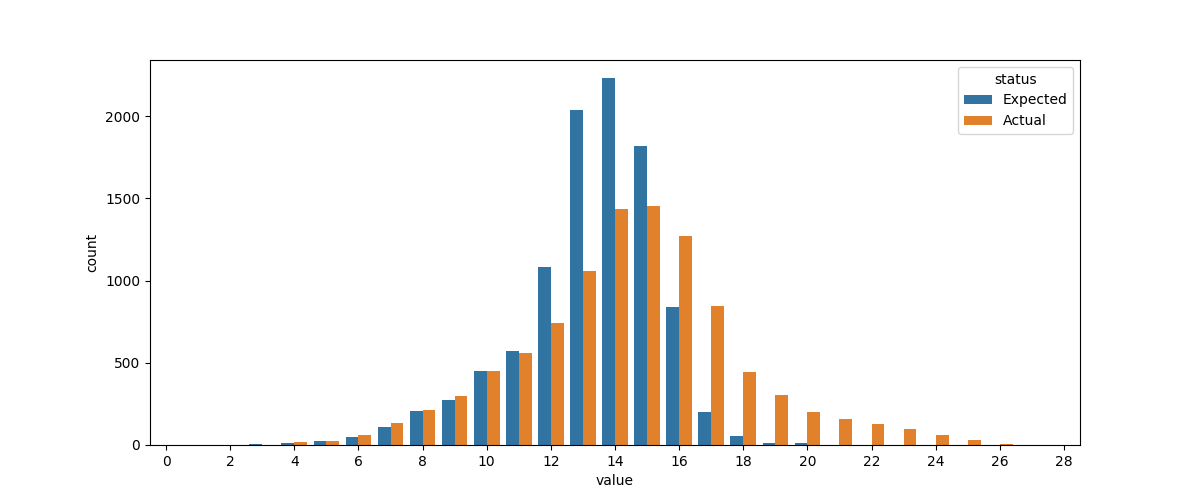

In [34]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.barplot(data=hist_shipping_days, x="value", y="count", hue="status")
x_ticks = list(range(0, 29, 2))
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks)
%matplot plt

As shown on the plot above, the actual delivery shipping dates have a right tail when compared to the forecasted ones. This indicates that a portion of the packages reach the customers later, than promissed. We may therefore take a look at the difference between ActualShippingDays and ExpectedShippingDays. A negative value will indicate that the package has been delivered earlier, than promissed, while a positive value is a sign of delay.

In [35]:
df = df.withColumn("ActualExpectedShippingDaysDiff", col("ActualShippingDays") - col("ExpectedShippingDays"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
df.select("ActualExpectedShippingDaysDiff").describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------------------+
|summary|ActualExpectedShippingDaysDiff|
+-------+------------------------------+
|  count|                         10000|
|   mean|                        1.1909|
| stddev|            2.0704313218713324|
|    min|                            -1|
|    max|                            10|
+-------+------------------------------+

<b>Conclusions #3:</b> According to the data contained in the dataset, the mean difference between actual shipping days and expected shipping days is 1.19, with a standard deviation of 2.07. As a rule of thumb, the packages do not tend to arrive earlier, with the earliest entry being delivered only 1 day in advance. The largest delay was equal to 10 days. This can be shown in the form of a histogram (below).

In [37]:
expected_and_actual_shipping_days_diff_hist = computeHistogram(df, "ActualExpectedShippingDaysDiff", -10, 10, 21).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

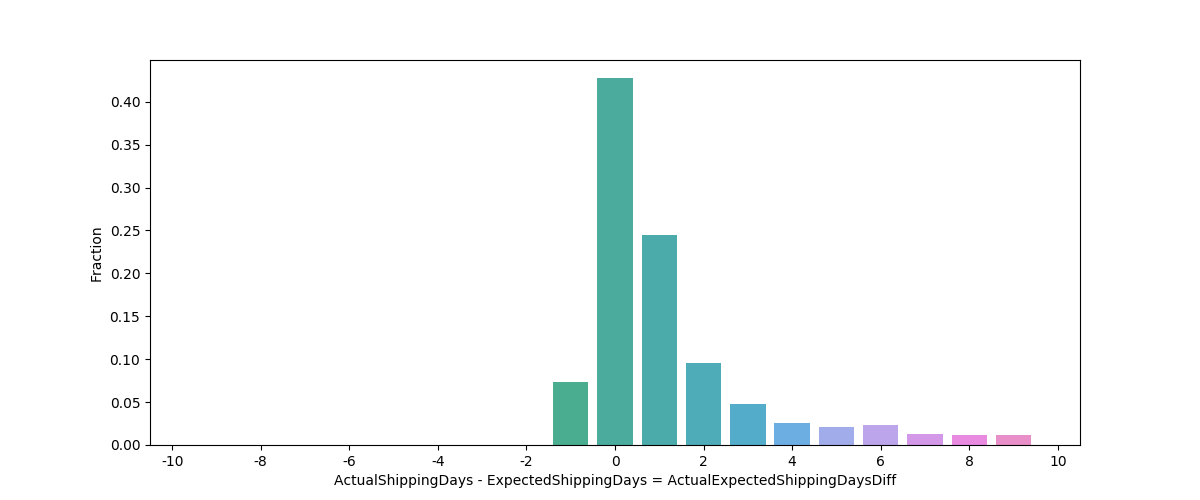

In [38]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.barplot(data=expected_and_actual_shipping_days_diff_hist / df.count(), x="value", y="count")
x_ticks = list(range(-10, 11, 2))
ax.set_xticks([x + 10 for x in x_ticks])
ax.set_ylabel("Fraction")
ax.set_xlabel("ActualShippingDays - ExpectedShippingDays = ActualExpectedShippingDaysDiff")
ax.set_xticklabels(x_ticks)
%matplot plt

Let us now examine the correlation between numerical features and ActualShippingDays/ExpectedShippingDays. The magnitude of correlation may hint as to which columns can potentially be useful in building the model.

In [39]:
def plot_correlation_matrix(df, columns, figsize=(12, 10), cmap="coolwarm", title=""):
    assembler = VectorAssembler(inputCols=columns, outputCol="corr_features")
    df_vector = assembler.transform(df).select("corr_features")

    matrix = Correlation.corr(df_vector, "corr_features").first()[0].values
    
    _, ax = plt.subplots(1, 1, figsize=figsize)
    dim = int(np.sqrt(matrix.shape[0]))
    labels = np.array([f"{v:.3f}" for v in matrix], dtype="str").reshape(dim, dim)
    x = sns.heatmap(matrix.reshape(dim, dim), annot=labels, linewidth=0.5, cmap=cmap, ax=ax, vmin=-1, vmax=1, fmt='')
    ax.set_xticklabels(columns, rotation=22.5, fontsize=8)
    ax.set_yticklabels(columns, rotation=0,  fontsize=8)
    ax.set_title(title)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

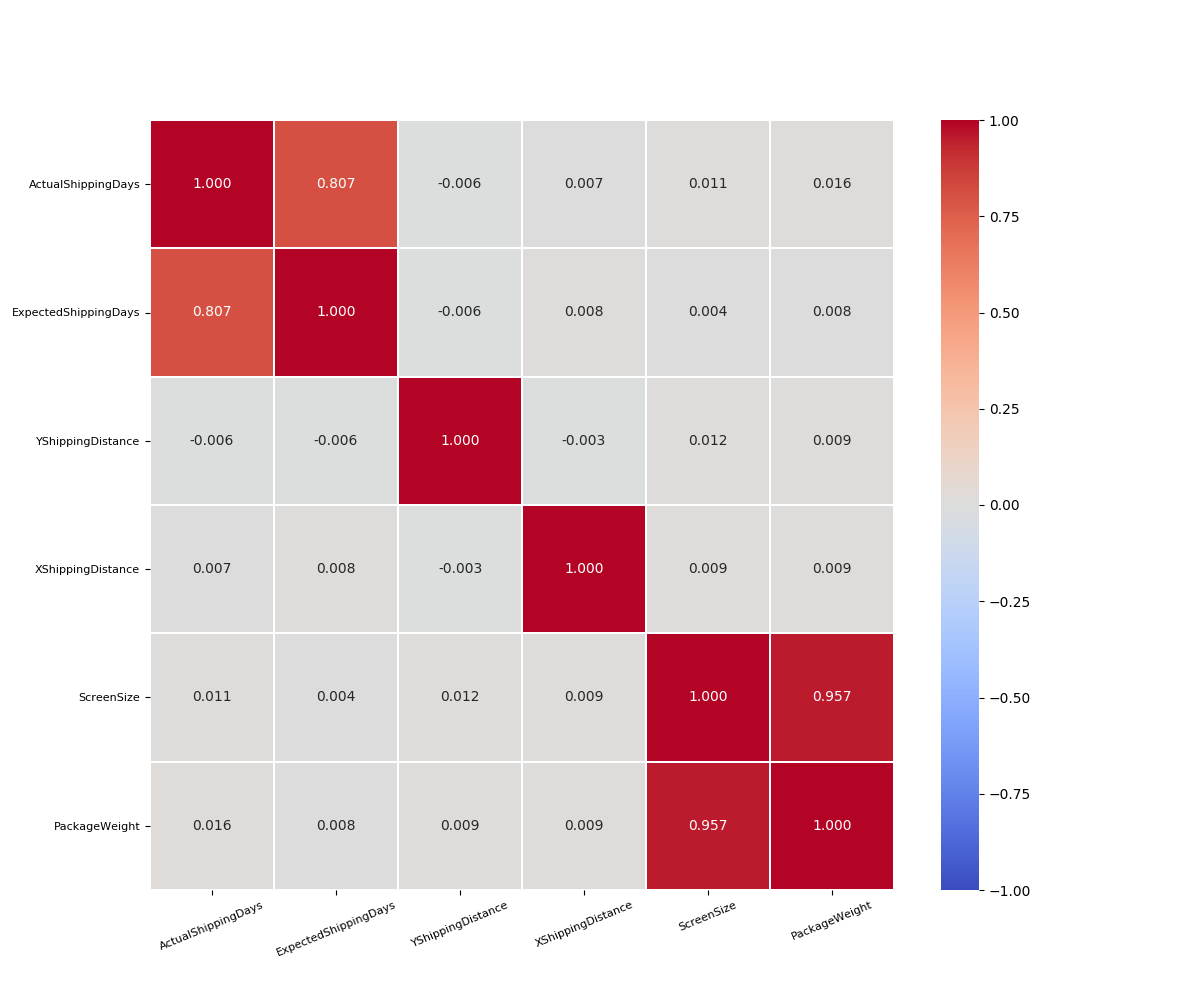

In [40]:
x = plot_correlation_matrix(df, columns=numerical_columns)
%matplot plt

There is negligable correlation between the shipping days and attributes such as screen size, package and weight. A little more surprising is the low magnitude of correlation between the shipping days and the distance of delivery. ExpectedShippingDays and ActualShippingDays show strong correlation, which is intuitive, even if there are some discrepencies between the values.

### Examine categorical columns' value distribution

Let us plot the counts of categories for each categorical column.

In [41]:
for c in categorical_columns:
    df.groupby(c).count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-----+
|      Carrier|count|
+-------------+-----+
|      Shipper| 2500|
| MicroCarrier| 2500|
|      BigBird| 2500|
|GlobalFreight| 2500|
+-------------+-----+

+------------+-----+
| InBulkOrder|count|
+------------+-----+
|  Bulk Order| 5000|
|Single Order| 5000|
+------------+-----+

+--------------+-----+
|ShippingOrigin|count|
+--------------+-----+
|       Atlanta| 1250|
|       Chicago| 1250|
|     Las Vegas| 1250|
|       Seattle| 1250|
| New York City| 1250|
|Salt Lake City| 1250|
| San Francisco| 1250|
|       Houston| 1250|
+--------------+-----+

+----------------+-----+
|ShippingPriority|count|
+----------------+-----+
|         Express| 2500|
|          Ground| 2500|
|        Standard| 2500|
|             Air| 2500|
+----------------+-----+

+--------------+-----+
|OnTimeDelivery|count|
+--------------+-----+
|       On Time| 7977|
|          Late| 2023|
+--------------+-----+

+-------------+-----+
|ComputerBrand|count|
+-------------+-----+
|       Orang

As it can be noticed, the categories seem equally distributed within a dataset. Also, for the considered time period, approx. 20% entries were delivered late.

### Plot correlation matrices of categorical values

Creating a correlation matrix for separate categories can give a hint as to what elements constitute towards an accurate prediction. In order to do this, we need to perform a one-hot-encoding of the categorical columns. <b>Note:</b> using PySpark's OneHotEncoder to carry out this process will result in a SparseVector object, which will not be useful in this case. Therefore, we carry out this process using custom code, presented below:

In [42]:
def one_hot_encode(df, column):
    categories = [it[0] for it in df.select(column).distinct().collect()]
    new_columns = []
    for category in categories:
        column_name = f"{column}_{category}"
        new_columns.append(column_name)
        df = df.withColumn(
            column_name,
            when(col(column) == category, 1).otherwise(0)
        )
    return df, new_columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### ComputerBrand

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

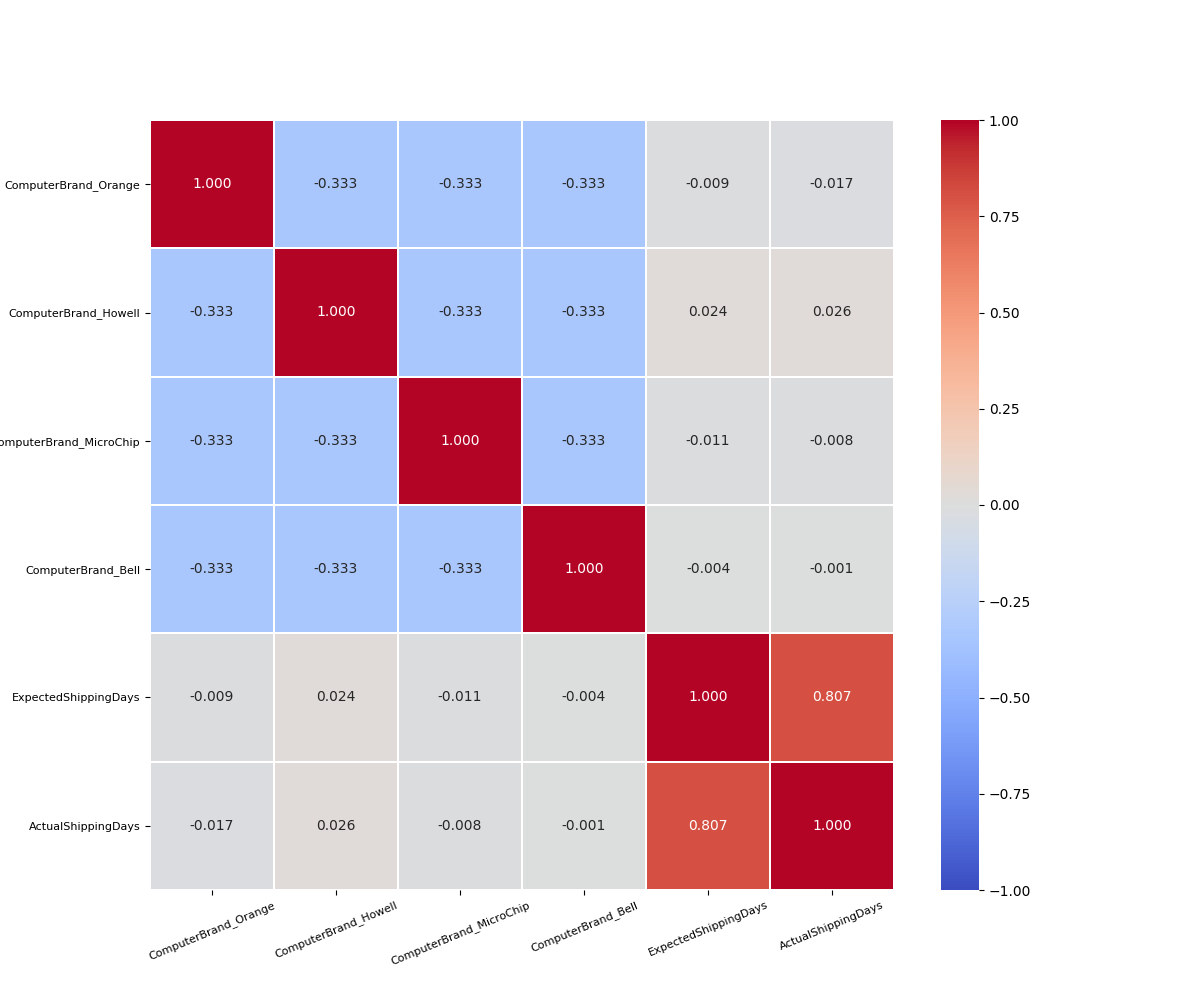

In [43]:
df, encoded_columns = one_hot_encode(df, "ComputerBrand")
plot_correlation_matrix(df, encoded_columns + ["ExpectedShippingDays", "ActualShippingDays"], cmap="coolwarm")
%matplot plt

The computer brand attribute doesn't seem to exhibit meaningful information in terms of predicting the shipping days. It may sometimes be the case that a specific brand is less available, causing delays, but this is clearly not the case with this data. Therefore it is safe to assume this column may be dropped before training.

#### ComputerModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

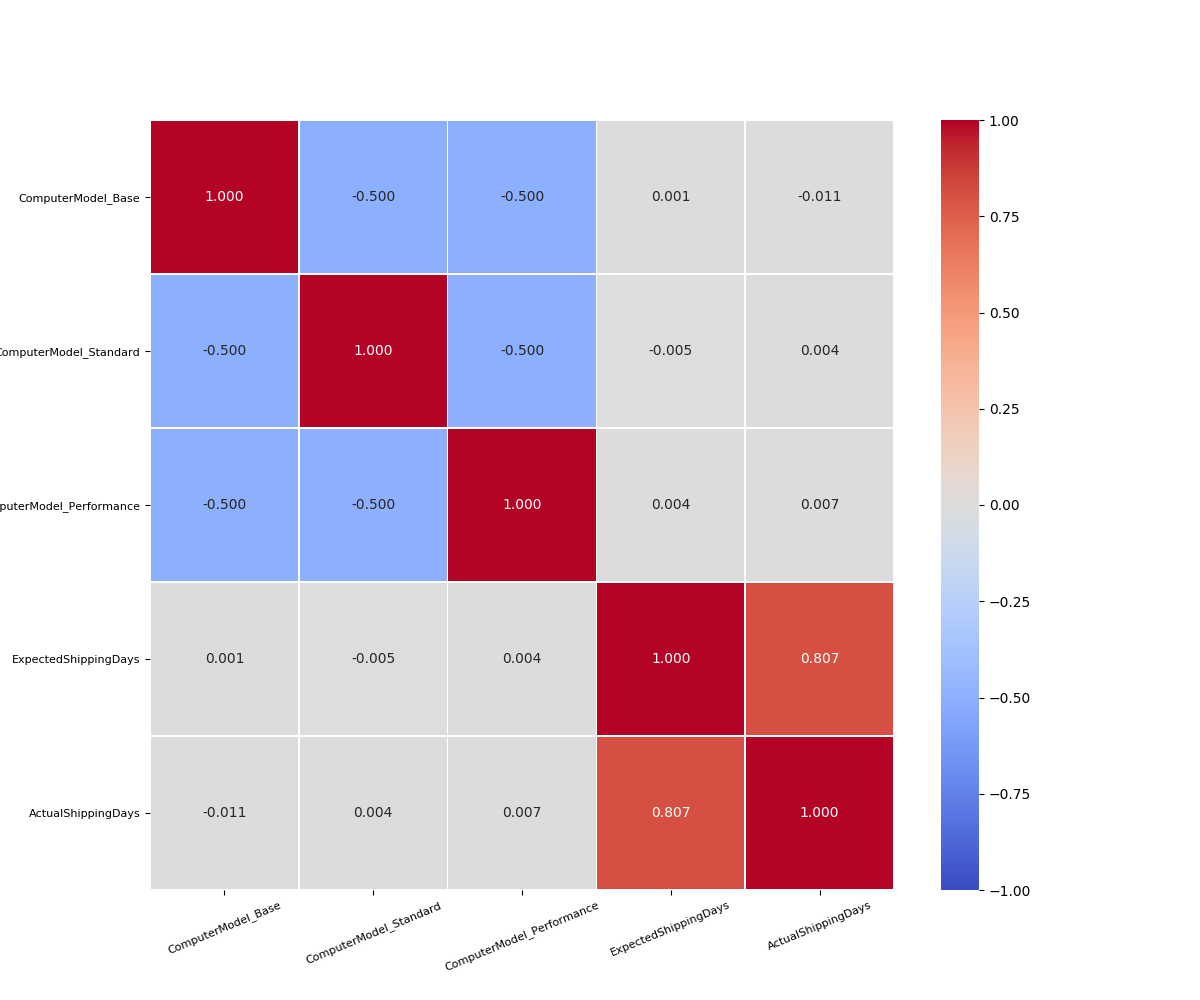

In [44]:
df, encoded_columns = one_hot_encode(df, "ComputerModel")
plot_correlation_matrix(df, encoded_columns + ["ExpectedShippingDays", "ActualShippingDays"], cmap="coolwarm")
%matplot plt

As with computer brand, this feature does not seem meaningful in terms of producing accurate shipping days predictions.

#### ShippingPriority

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

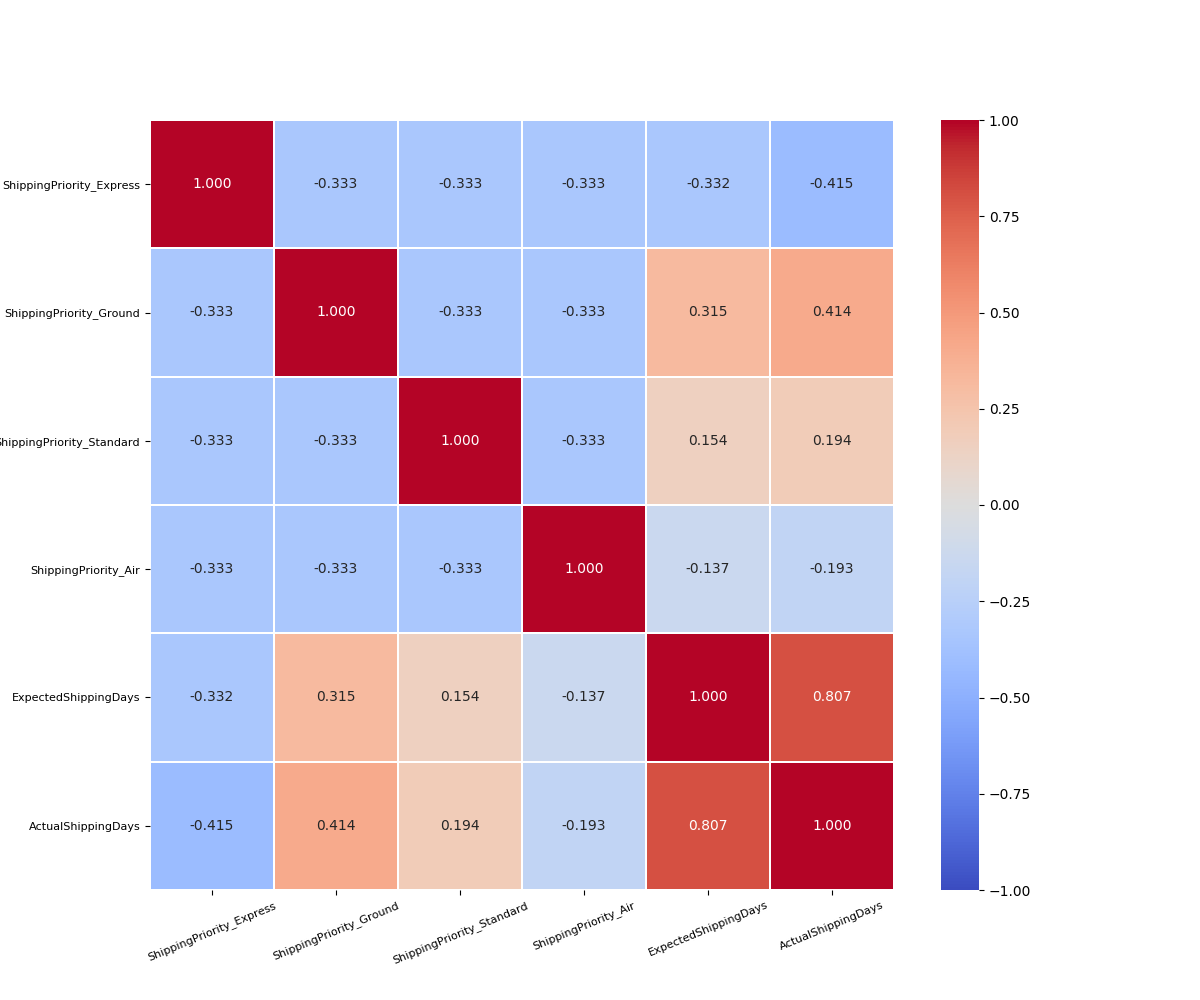

In [45]:
df, encoded_columns = one_hot_encode(df, "ShippingPriority")
plot_correlation_matrix(df, encoded_columns + ["ExpectedShippingDays", "ActualShippingDays"])
%matplot plt

The <i>Express</i> shipping priority exhibits a correlation of -0.415 with ActualShippingDays, meaning that entries of this category tend to be delivered faster, which is what one may expect. A smaller correlation magnitude, but still corresponding to faster delivery times, is seen for the <i>Air</i> category.

On the other hand, <i>Ground</i> deliveries, with a correlation of 0.414 with ActualShippingDays, correspond to slower deliveries, as is the case with the <i>Standard</i> shipping priority.

#### Carrier

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

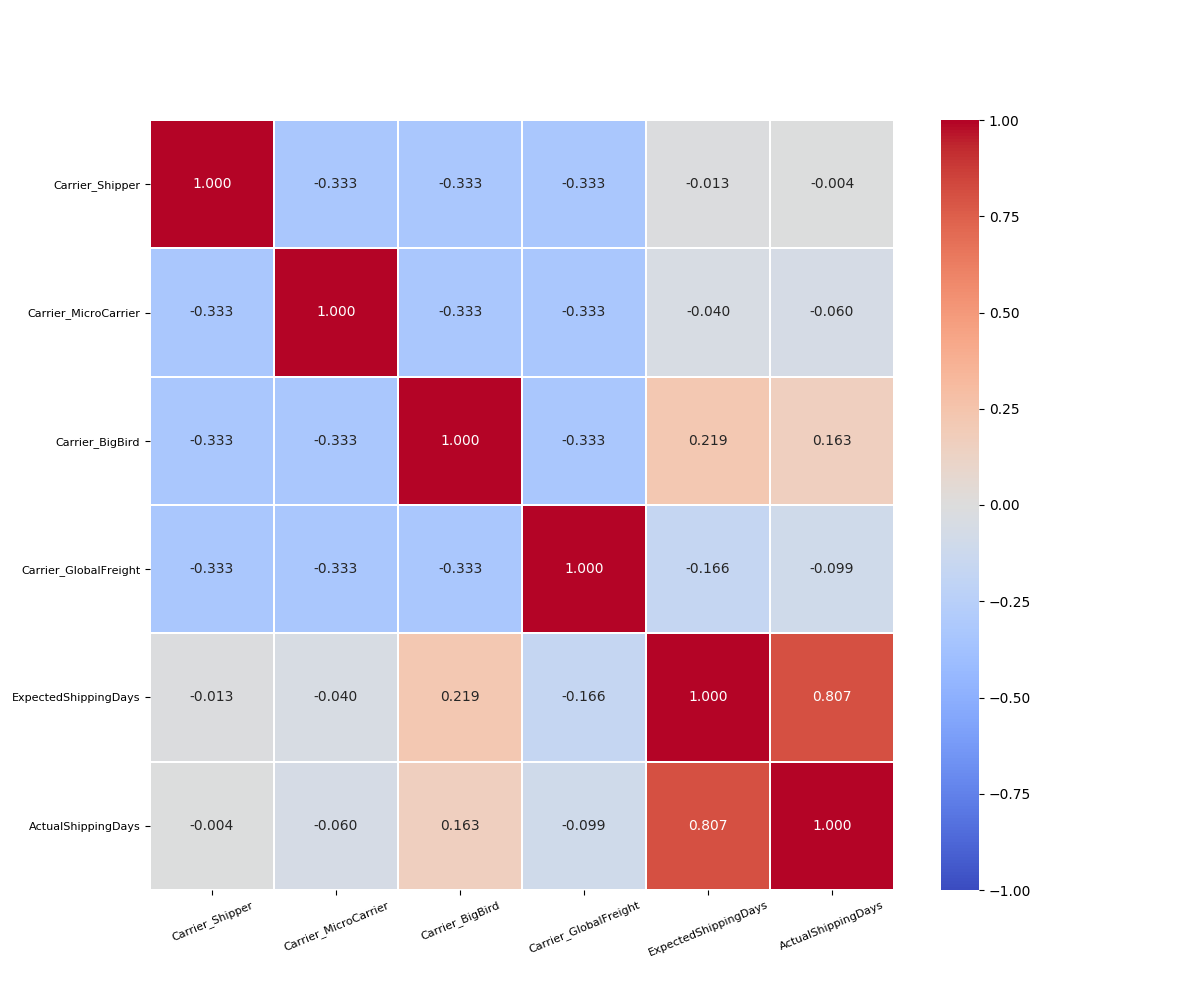

In [46]:
df, encoded_columns = one_hot_encode(df, "Carrier")
plot_correlation_matrix(df, encoded_columns + ["ExpectedShippingDays", "ActualShippingDays"])
%matplot plt

The <i>BigBird</i> carrier stands out as the one with a positive correlation with ActualShippingDays, meaning that this category constitutes towards longer deliveries. The other carriers exhibit low negative correlation. In order to reduce the number of columns, we may think obout aggregating them into an <i>Carrier_OTHER</i> "bag".

#### ShippingOrigin

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

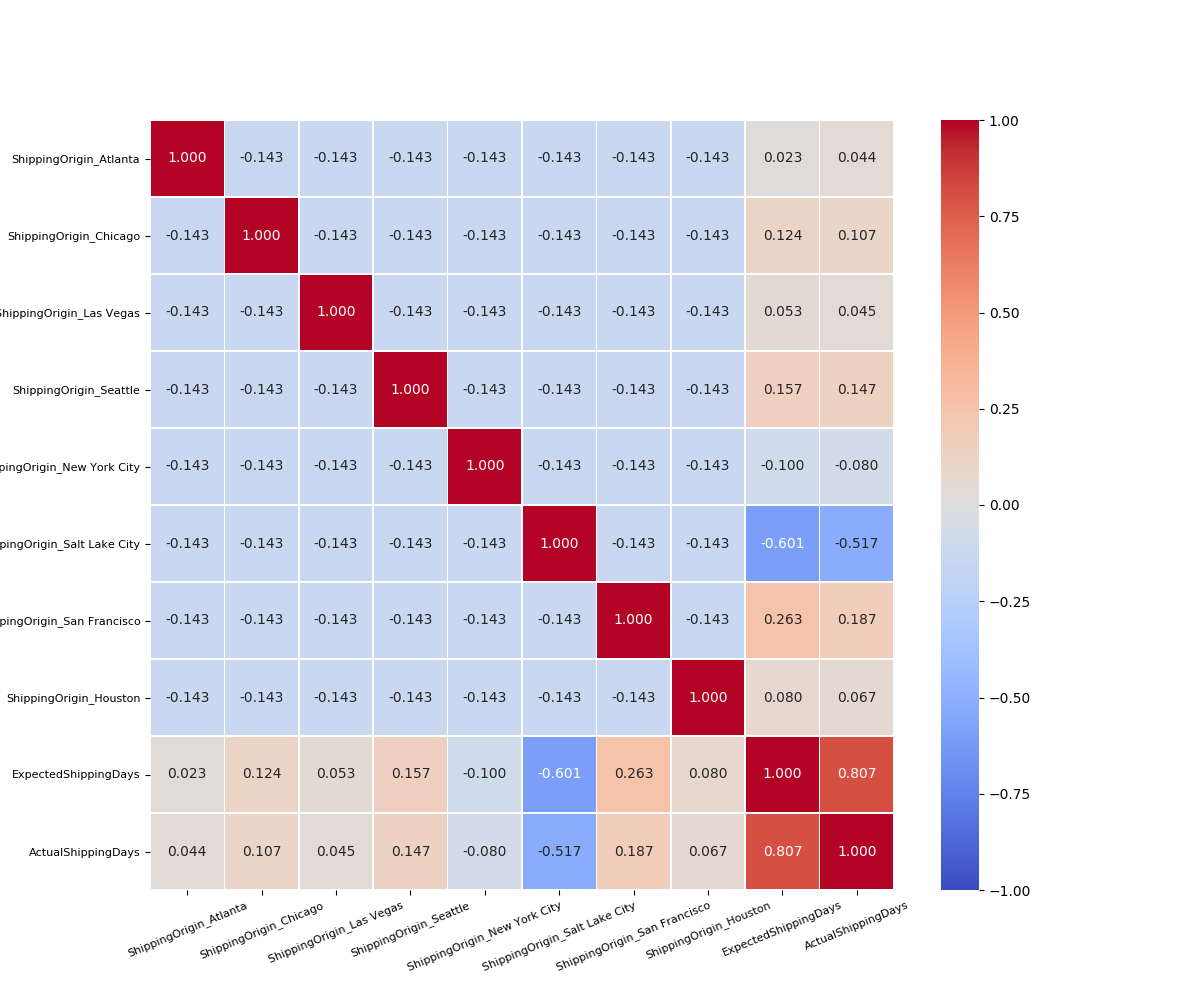

In [47]:
df, encoded_columns = one_hot_encode(df, "ShippingOrigin")
plot_correlation_matrix(df, encoded_columns + ["ExpectedShippingDays", "ActualShippingDays"])
%matplot plt

It can be noticed that shipments originating from Salt Lake City tend to have a lower delivery time. On the other hand, packages sent from Chicago, Seattle and San Francisco exhibit > 0.1 correlation with ActualShippingDays. The remaining categories' magnitude is below 10%.

#### InBulkOrder

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

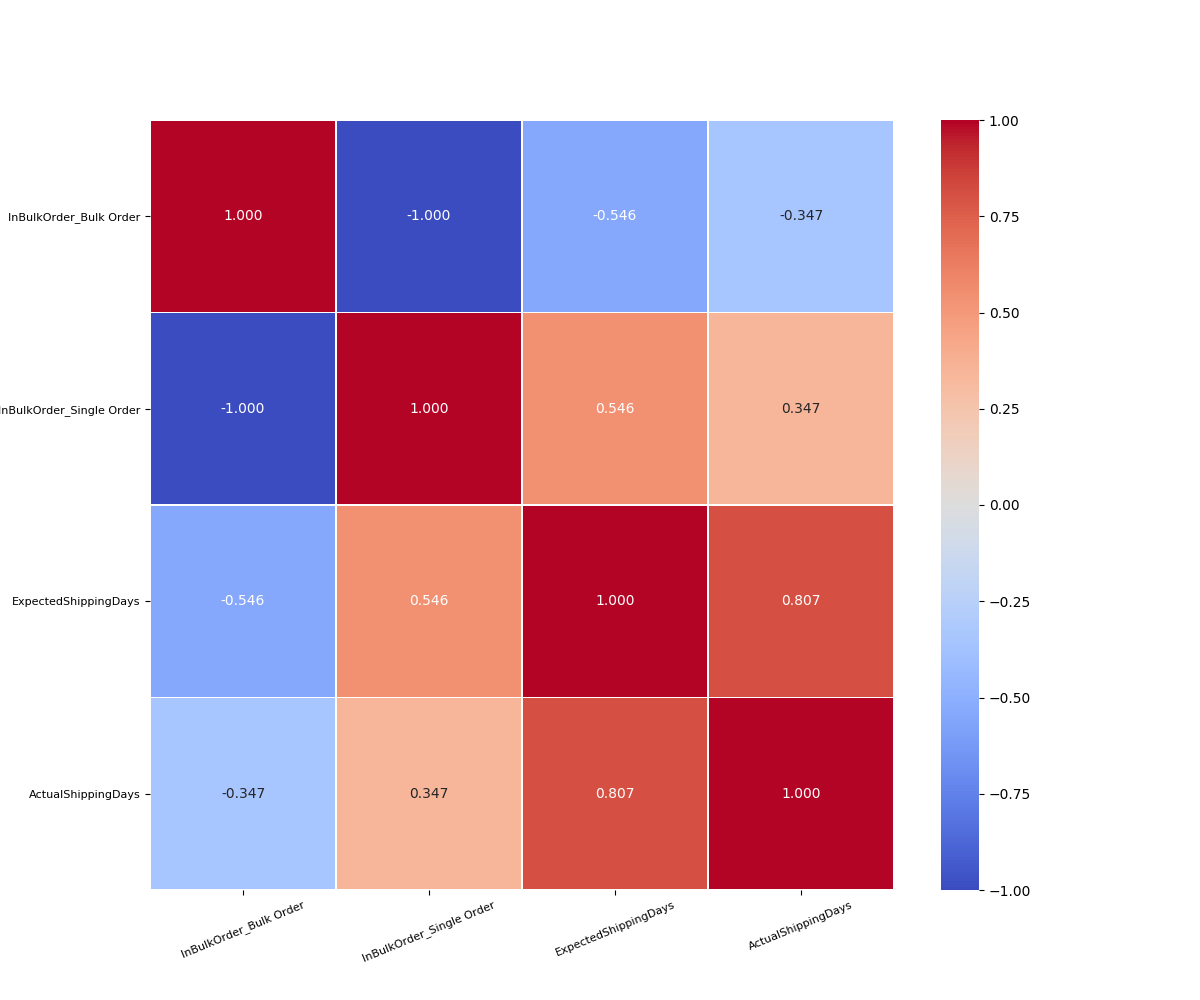

In [48]:
df, encoded_columns = one_hot_encode(df, "InBulkOrder")
plot_correlation_matrix(df, encoded_columns + ["ExpectedShippingDays", "ActualShippingDays"])
%matplot plt

It can be noticed that bulk orders tend to have a shorted delivery time (negative correlation), than individual orders. Therefore this information may be a useful element for the machine learning model.

## User-defined features

#### Column transformation

The columns available "out of the box" can be used to generate new features. An example can be using <i>XShippingDistance</i> and <i>YShippingDistance</i> to create a feature called <i>EucledeanShippingDistance</i>:

$EucledeanShippingDistance = \sqrt{XShippingDistance^2 + YShippingDistance^2}$.

This column can be created using PySpark dataframe's <i>withColumn</i> method.

<b>Note:</b> Calculating the distance in such a way obviously doesn't consider the z-axis, related to the Earth's curvature. The implications of assuming local flatness would have to be carefully considered in a production setting. 

In [49]:
df = df.withColumn(
    "EucledeanShippingDistance",
    sqrt(pow_spark(col("XShippingDistance"), 2) + pow_spark(col("YShippingDistance"), 2))
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
for c in ("XShippingDistance", "YShippingDistance", "EucledeanShippingDistance"):
    corr = df.corr("ActualShippingDays", c)
    print(f"Correlation between ActualShippingDays and {c}: {corr:.5f}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Correlation between ActualShippingDays and XShippingDistance: 0.00663
Correlation between ActualShippingDays and YShippingDistance: -0.00556
Correlation between ActualShippingDays and EucledeanShippingDistance: 0.40459

As can be seen, despite XShippingDistance and YShippingDistance exhibiting negligable correlation with the target column, calculating the Euclidean distance provides a correlation of ~0.4 with ActualShippingDays.

### 2nd order polynomial features

We may create polynomial features and measure the correlation with ActualShippingDays. To do this, we will use the previously processed numeric columns. Since the number of features grows as O(N^k), where N is the length of the feature array and k is the polynomial degree, we will limit ourselves to calculating the quadratic features.

In [51]:
numeric_columns = [c for c, dtype in df.dtypes if dtype in numerical_types and "ShippingDays" not in c]
numeric_columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['YShippingDistance', 'XShippingDistance', 'ScreenSize', 'PackageWeight', 'ComputerBrand_Orange', 'ComputerBrand_Howell', 'ComputerBrand_MicroChip', 'ComputerBrand_Bell', 'ComputerModel_Base', 'ComputerModel_Standard', 'ComputerModel_Performance', 'ShippingPriority_Express', 'ShippingPriority_Ground', 'ShippingPriority_Standard', 'ShippingPriority_Air', 'Carrier_Shipper', 'Carrier_MicroCarrier', 'Carrier_BigBird', 'Carrier_GlobalFreight', 'ShippingOrigin_Atlanta', 'ShippingOrigin_Chicago', 'ShippingOrigin_Las Vegas', 'ShippingOrigin_Seattle', 'ShippingOrigin_New York City', 'ShippingOrigin_Salt Lake City', 'ShippingOrigin_San Francisco', 'ShippingOrigin_Houston', 'InBulkOrder_Bulk Order', 'InBulkOrder_Single Order', 'EucledeanShippingDistance']

Since using PySpark's [PolynomialExpansion](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.PolynomialExpansion.html) requires overhead, it will be easier to use a nested loop to caucluate column_1 * column_2 terms.

In [52]:
new_column_names = []
for idx_1 in range(len(numeric_columns)):
    for idx_2 in range(idx_1 + 1, len(numeric_columns)):
        c1 = numeric_columns[idx_1]
        c2 = numeric_columns[idx_2]
        new_column_name = f"{c1}_times_{c2}"
        df = df.withColumn(new_column_name, col(c1) * col(c2))
        new_column_names.append(new_column_name)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In order to calculate the correlation matrix, the calculated features need to be assembled using VectorAssembler. 

In [53]:
output_col_name = "polynomial_cols_assembled"
assembler = VectorAssembler(inputCols=[*new_column_names, "ActualShippingDays"], outputCol=output_col_name)
df_tmp = assembler.transform(df).select(output_col_name)

correlation_matrix = Correlation.corr(df_tmp, output_col_name)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Finally, we can collect the calculated matrix to array. We take the "-1" index of correlation_matrix_arr, which corresponds to correlation with the last element of VectorAssembler's inputCols, which is the desired <i>ActualShippingDays</i>. For this array, we call [:-1] to drop the last element, which corresponds to corr("ActualShippingDays", "ActualShippingDays") == 1. The ordering of the resulting array is consistent with the elements of new_column_names.

In [54]:
correlation_matrix_arr = correlation_matrix.first()[0].toArray()
quadratic_features_by_correlation = sorted(
    zip(correlation_matrix_arr[-1][:-1], new_column_names),
    reverse=True,
    key=lambda it: abs(it[0])
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We print the top-10 features based on correlation magnitude.

In [55]:
print("Correlation with ActualShippingDays")
for corr, feature in quadratic_features_by_correlation[:10]:
    print(f"{feature} correlation: {corr}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Correlation with ActualShippingDays
ScreenSize_times_ShippingOrigin_Salt Lake City correlation: -0.5076511821520022
PackageWeight_times_ShippingOrigin_Salt Lake City correlation: -0.5056665997415954
ScreenSize_times_ShippingPriority_Express correlation: -0.4064005606445699
PackageWeight_times_ShippingPriority_Express correlation: -0.40546813303227336
ScreenSize_times_ShippingPriority_Ground correlation: 0.40461910485157637
PackageWeight_times_ShippingPriority_Ground correlation: 0.4042101453290761
ScreenSize_times_EucledeanShippingDistance correlation: 0.36850152546580756
PackageWeight_times_EucledeanShippingDistance correlation: 0.36589869780318596
PackageWeight_times_InBulkOrder_Single Order correlation: 0.33730017593150036
ScreenSize_times_InBulkOrder_Single Order correlation: 0.33711888252609995

Such features can be used during a 2nd iteration of feature engineering to check whether improvement is gained as compared to using only the basic columns list.

## Order dates

In [56]:
distinct_dates = sorted([r[0] for r in df.select("OrderDate").distinct().collect()])

print(f"Number of distinct dates: {len(distinct_dates)}")
print(f"Earliest date: {distinct_dates[0]}")
print(f"Latest date: {distinct_dates[-1]}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of distinct dates: 730
Earliest date: 2020-01-01
Latest date: 2021-12-30

In [57]:
df_shipping_days_by_date = df.select("OrderDate", "ActualShippingDays", "ActualExpectedShippingDaysDiff").toPandas()
df_shipping_days_by_date = df_shipping_days_by_date.sort_values(by="OrderDate")

df_shipping_days_by_date["ActualShippingDaysWeekly"] = df_shipping_days_by_date["ActualShippingDays"].rolling(window=7).mean()
df_shipping_days_by_date["ActualShippingDaysMonthly"] = df_shipping_days_by_date["ActualShippingDays"].rolling(window=30).mean()

df_shipping_days_by_date["ActualExpectedShippingDaysDiffWeekly"] = df_shipping_days_by_date["ActualExpectedShippingDaysDiff"].rolling(window=7).mean()
df_shipping_days_by_date["ActualExpectedShippingDaysDiffMonthly"] = df_shipping_days_by_date["ActualExpectedShippingDaysDiff"].rolling(window=30).mean()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

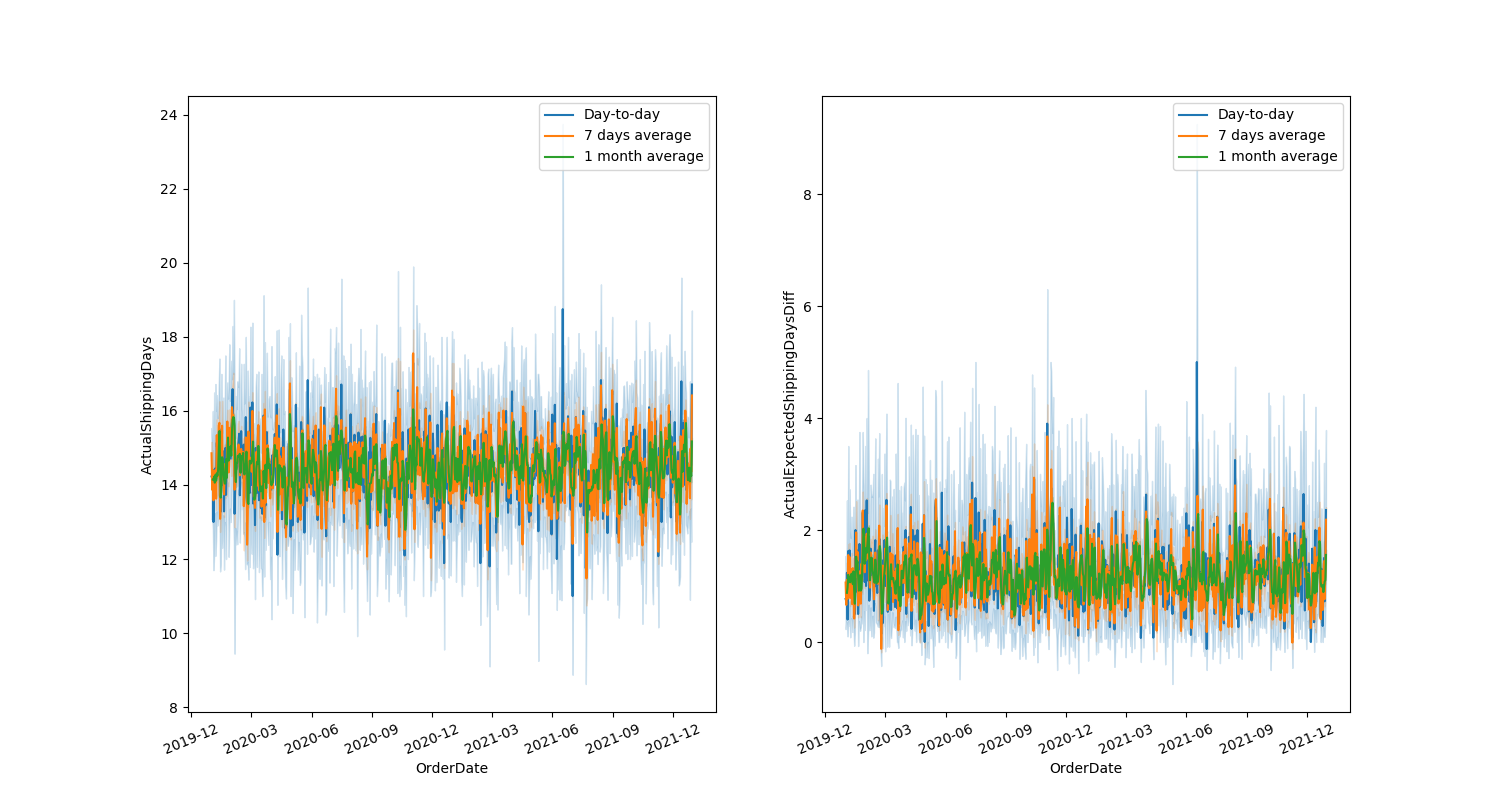

In [58]:
_, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.lineplot(data=df_shipping_days_by_date, x="OrderDate", y="ActualShippingDays", ax=axs[0])
sns.lineplot(data=df_shipping_days_by_date, x="OrderDate", y="ActualShippingDaysWeekly", ax=axs[0])
sns.lineplot(data=df_shipping_days_by_date, x="OrderDate", y="ActualShippingDaysMonthly", ax=axs[0])
axs[0].set_ylabel("ActualShippingDays")

sns.lineplot(data=df_shipping_days_by_date, x="OrderDate", y="ActualExpectedShippingDaysDiff", ax=axs[1])
sns.lineplot(data=df_shipping_days_by_date, x="OrderDate", y="ActualExpectedShippingDaysDiffWeekly", ax=axs[1])
sns.lineplot(data=df_shipping_days_by_date, x="OrderDate", y="ActualExpectedShippingDaysDiffMonthly", ax=axs[1])
axs[1].set_ylabel("ActualExpectedShippingDaysDiff")

for ax in axs:
    ax.legend(["Day-to-day", "7 days average", "1 month average"])

%matplot plt
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=22.5)
%matplot plt

Plotting both the day-to-day values of ActualShippingDays, as well as the 7 day and 30 day averages, shows no seasonality, neither does it hint about a trend of the average shipping days increase/decrease. A similar observation is true for ActualExpectedShippingDaysDiff - the discrepency between actual and expected shipping days varies randomly. No positive or negative trend is observed. 

In order to divide the dataset into the training and validation subsets, we will use the OrderDate column. Let us check whether the dataset grows in a linear fashion, or whether there are periods of more intensive growth. To achieve this, we will create a cumulative fraction indicating the fraction of entries on or before that date.

In [59]:
entries_by_date = df_shipping_days_by_date.groupby("OrderDate").count().ActualShippingDays.rename("Cumulative fraction", axis=1)
cummulative_fraction = (entries_by_date.cumsum() / entries_by_date.sum()).reset_index(drop=False)
cummulative_fraction

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      OrderDate  Cumulative fraction
0    2020-01-01               0.0013
1    2020-01-02               0.0024
2    2020-01-03               0.0041
3    2020-01-04               0.0051
4    2020-01-05               0.0059
..          ...                  ...
725  2021-12-26               0.9950
726  2021-12-27               0.9960
727  2021-12-28               0.9971
728  2021-12-29               0.9986
729  2021-12-30               1.0000

[730 rows x 2 columns]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

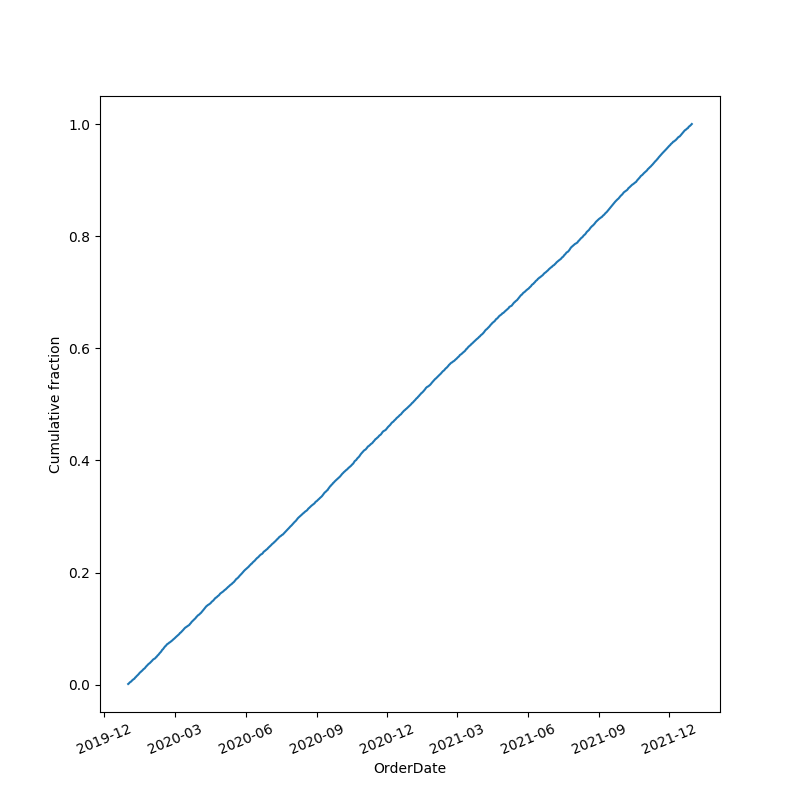

In [60]:
_, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.lineplot(data=cummulative_fraction, x="OrderDate", y="Cumulative fraction", ax=ax)
%matplot plt
ax.set_xticklabels(ax.get_xticklabels(), rotation=22.5)
%matplot plt

As can be seen above, data accumulates at a constant rate, which means it will be easy to approximate the train/validation cutoff date.